<a href="https://colab.research.google.com/github/ko-mori-dev/SuperTrend-Indicator/blob/dev/test_SuperTrend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

27a9bdb30ab547f687a43aa7fd1ef8fe

In [ ]:
pip install twelvedata websocket

     |████████████████████████████████| 40 kB 2.6 MB/s 
     |████████████████████████████████| 195 kB 4.8 MB/s 
     |████████████████████████████████| 5.8 MB 36.4 MB/s 
     |████████████████████████████████| 251 kB 37.7 MB/s 
  Created wheel for websocket: filename=websocket-0.2.1-py3-none-any.whl size=192132 sha256=079e66a84c93ee93a7e2ce5d7229009ab17a41b73a2a73df3baeb4efa7383107
  Stored in directory: /root/.cache/pip/wheels/e2/9b/2b/6324f465ec5543e33a31c2692c01c1760173bbb98b37dbaee8
Successfully built websocket


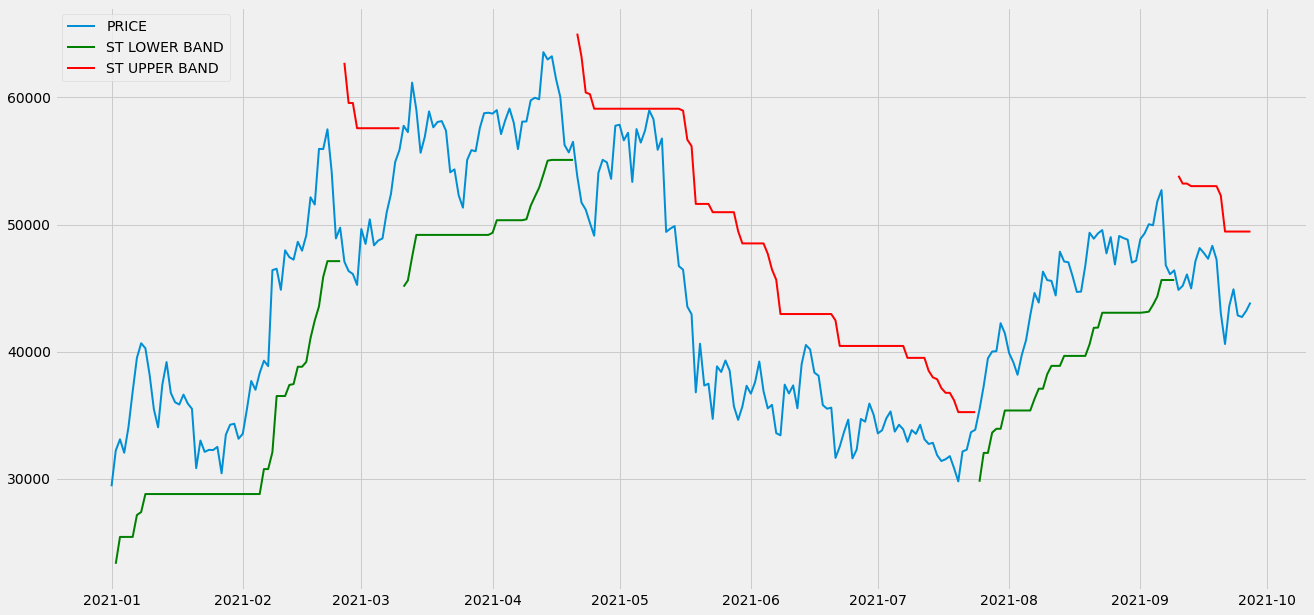

In [ ]:
# 各種パッケージを読み込み
import datetime
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)
import requests
from termcolor import colored as cl
from twelvedata import TDClient
import warnings
warnings.filterwarnings('ignore')

# Twelve DataのAPIキー
TWELVE_DATA_API_KEY = '27a9bdb30ab547f687a43aa7fd1ef8fe'

# ヒストリカルデータを取得
def get_historical_data(symbol, interval, exchange, outputsize, start_date, end_date, timezone):
    td = TDClient(apikey = TWELVE_DATA_API_KEY)

    res = td.time_series(
              symbol = symbol,
              interval = interval,
              exchange = exchange,
              outputsize = outputsize,
              start_date = start_date,
              end_date = end_date,
              timezone = timezone
          ).as_json()

    df = pd.DataFrame(res).iloc[::-1].set_index('datetime').astype(float)
    df = df[df.index >= start_date]
    df.index = pd.to_datetime(df.index)

    return df

# SuperTrendを作成（look_back: 振り返り期間、 multiplier: 乗数）
def make_super_trend(df, look_back = 10, multiplier = 3):
    high = df['high']
    low = df['low']
    close = df['close']

    # ATR（アベレージ・トゥルー・レンジ = （当日の高値 - 当日の安値）、 （当日の高値 - 前日の終値）、 （当日の安値 - 前日の終値） のうち最も大きい値）
    tr1 = pd.DataFrame(high - low)                # 当日の高値 - 当日の安値
    tr2 = pd.DataFrame(abs(high - close.shift(1))) # 当日の高値 - 前日の終値
    tr3 = pd.DataFrame(abs(low  - close.shift(1)))  # 当日の安値 - 前日の終値    
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(look_back).mean()

    # バンド上限、バンド下限を計算
    hl_avg = (high + low ) / 2
    st_lower_band = (hl_avg - multiplier * atr).dropna()
    st_upper_band = (hl_avg + multiplier * atr).dropna()
    is_up_trend = np.zeros(len(df)) # 「is_up_trend」が1なら上昇トレンド、0なら下降トレンド

    for i in range(len(df.index)):
        current = i
        previous = i - 1

        if close[current] > st_upper_band[previous]: # 現在の終値が前のバンド上限を上回っていた場合は上昇トレンドと判定
            is_up_trend[current] = 1
        elif close[current] < st_lower_band[previous]: # 現在の終値が前のバンド下限を下回っていた場合は下降トレンドと判定
            is_up_trend[current] = 0
        else:
            is_up_trend[current] = is_up_trend[previous]

            if is_up_trend[current] == 1 and st_lower_band[current] < st_lower_band[previous]: # 上昇トレンドかつ現在のバンド下限が前のバンド下限を下回っていた場合は前のバンド下限が継続
                st_lower_band[current] = st_lower_band[previous]
            elif is_up_trend[current] == 0 and st_upper_band[current] > st_upper_band[previous]: # 下降トレンドかつ現在のバンド上限が前のバンド上限を上回っていた場合は前のバンド上限が継続
                st_upper_band[current] = st_upper_band[previous]

    # 上昇トレンドの場合はバンド上限を消し、下降トレンドの場合はバンド下限を消す
    for i in range(len(df.index)):
        if is_up_trend[i] == 1:
            st_upper_band[i] = np.nan
        elif is_up_trend[i] == 0:
            st_lower_band[i] = np.nan

    return st_lower_band, st_upper_band

# 銘柄
symbol = 'BTC/USD'

# 時間軸
interval = '1day'

# 取引所
exchange = 'BitStamp'

# 取得件数
outputsize = 5000

# 取得開始日
start_date = '2021-01-01'

# 取得終了日
end_date = datetime.datetime.now().strftime('%Y-%m-%d')

# タイムゾーン
timezone = 'Asia/Tokyo'

# ヒストリカルデータを取得
df = get_historical_data(symbol, interval, exchange, outputsize, start_date, end_date, timezone)

# SuperTrendを作成
df['st_lower_band'], df['st_upper_band'] = make_super_trend(df, 10, 3)

# チャート描画
plt.plot(df['close'], linewidth = 2, label = 'PRICE')
plt.plot(df['st_lower_band'], color = 'green', linewidth = 2, label = 'ST LOWER BAND')
plt.plot(df['st_upper_band'], color = 'red', linewidth = 2, label = 'ST UPPER BAND')
plt.legend(loc = 'upper left')
plt.show()